
# Star clustering

Цель: выполнить EDA, подготовку данных, кластеризацию разными алгоритмами и сравнить результаты с истинными метками.



## 1. Импорт библиотек


In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
from sklearn.neighbors import NearestNeighbors

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 110



## 2. Загрузка данных


In [17]:

path = Path("star_classification.csv")
assert path.exists(), "CSV не найден"
df = pd.read_csv(path)
print(df.shape)
df.head()


(100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842



## 3. Распределение классов и проверка качества данных

В исходных данных встречаются значения `-9999` — это технический код пропуска. 
Если строить гистограммы без обработки, получается один «столбик», потому что диапазон резко расширяется.


In [18]:

# Замена технических пропусков на NaN
for col in ['u','g','r','i','z']:
    df.loc[df[col] == -9999, col] = np.nan

print(df['class'].value_counts())
print("Пропуски по фотометрии:")
print(df[['u','g','r','i','z']].isna().sum())


class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64
Пропуски по фотометрии:
u    1
g    1
r    0
i    0
z    1
dtype: int64



## 4. EDA: распределения и корреляции

Ниже гистограммы строятся уже без `-9999`, поэтому они отражают реальные диапазоны значений.


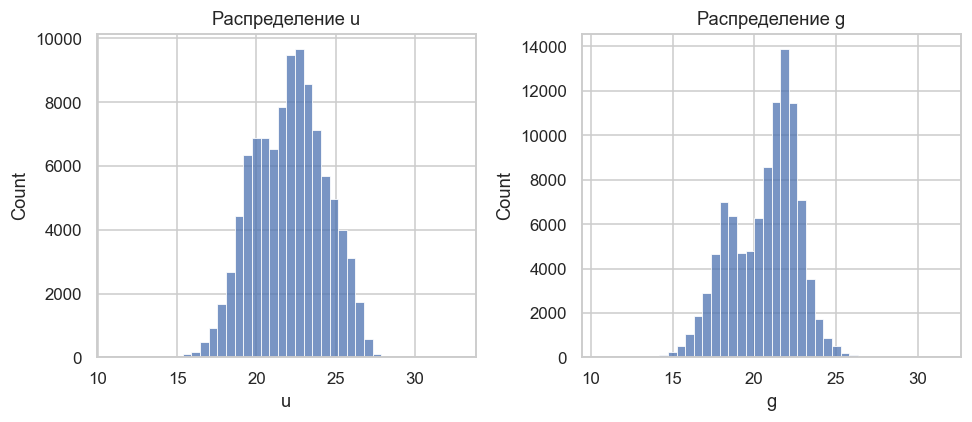

In [19]:

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.histplot(df['u'].dropna(), bins=40, ax=axes[0])
axes[0].set_title("Распределение u")

sns.histplot(df['g'].dropna(), bins=40, ax=axes[1])
axes[1].set_title("Распределение g")

plt.tight_layout()
plt.show()



### Корреляции

Для фотометрических полос ожидаемо сильная положительная корреляция между соседними диапазонами (u–g, g–r и т.д.).
Корреляция `redshift` с полосами помогает отделять объекты по космологической дистанции.


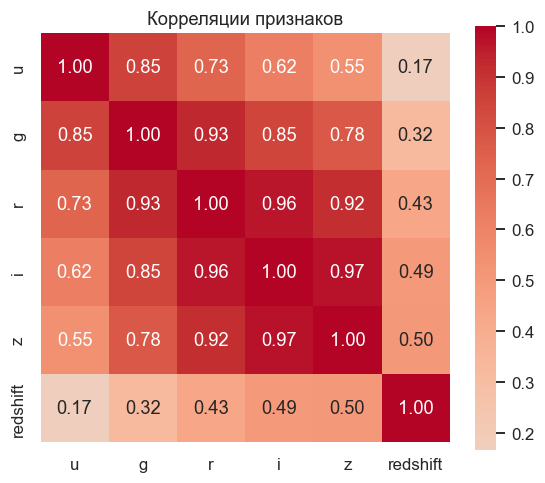

In [20]:

cluster_features = ['u','g','r','i','z','redshift']

# чистая таблица без пропусков в выбранных признаках
df_clean = df.dropna(subset=cluster_features)

corr = df_clean[cluster_features].corr(numeric_only=True)
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Корреляции признаков")
plt.show()



## 5. Подготовка данных

Для кластеризации используем фотометрию и `redshift`. ID‑поля исключаем.
Выбросы обрезаем по 1/99‑квантилям, затем стандартизируем.


In [21]:

X_raw = df_clean[cluster_features]

# Отсечение выбросов
lower = X_raw.quantile(0.01)
upper = X_raw.quantile(0.99)
X_clipped = X_raw.clip(lower, upper, axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clipped)

print("Размерность после очистки:", X_scaled.shape)


Размерность после очистки: (99999, 6)



## 6. PCA: объясненная дисперсия и состав первой компоненты

Покажем, сколько дисперсии объясняет каждая компонента, и какие признаки сильнее всего формируют первую компоненту.


PC1    0.755609
PC2    0.156874
PC3    0.068622
PC4    0.014498
PC5    0.002961
PC6    0.001435
dtype: float64
Вклад признаков в PC1 (по модулю):
r           0.463158
i           0.454330
g           0.440029
z           0.437332
u           0.361281
redshift    0.252309
dtype: float64


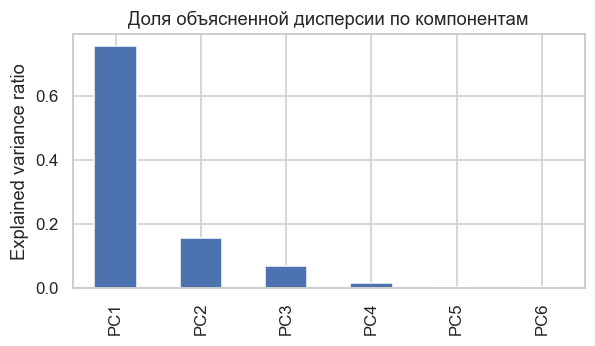

In [22]:

pca_full = PCA(n_components=len(cluster_features), random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

explained = pd.Series(pca_full.explained_variance_ratio_,
                      index=[f"PC{i+1}" for i in range(len(cluster_features))])
print(explained)

loadings_pc1 = pd.Series(pca_full.components_[0], index=cluster_features)
loadings_pc1 = loadings_pc1.reindex(loadings_pc1.abs().sort_values(ascending=False).index)
print("Вклад признаков в PC1 (по модулю):")
print(loadings_pc1)

plt.figure(figsize=(6, 3))
explained.plot(kind="bar")
plt.title("Доля объясненной дисперсии по компонентам")
plt.ylabel("Explained variance ratio")
plt.show()



Если веса в PC1 близки по модулю и одного знака, то первая компонента описывает общую яркость объекта (сдвиг всех полос одновременно). 



## 7. PCA: сравнение 3 и 4 компонент

Проверим качество кластеризации при 3 и 4 PCA‑признаках.


In [23]:

# Подвыборка для ускорения
rng = np.random.default_rng(42)
sample_size = 20000
sample_idx = rng.choice(len(X_scaled), size=sample_size, replace=False)
y_sample = df_clean['class'].iloc[sample_idx].to_numpy()

pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_scaled)
X_pca3_s = X_pca3[sample_idx]

pca4 = PCA(n_components=4, random_state=42)
X_pca4 = pca4.fit_transform(X_scaled)
X_pca4_s = X_pca4[sample_idx]

rows = []
for name, Xs in [("PCA3", X_pca3_s), ("PCA4", X_pca4_s)]:
    km = KMeans(n_clusters=3, n_init=10, random_state=42).fit(Xs)
    gmm = GaussianMixture(n_components=3, random_state=42).fit(Xs)
    agg = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(Xs)

    for algo, lab in [("kmeans", km.labels_), ("gmm", gmm.predict(Xs)), ("agg", agg.labels_)]:
        rows.append({
            "pca": name,
            "algo": algo,
            "ARI": adjusted_rand_score(y_sample, lab),
            "V": v_measure_score(y_sample, lab),
            "silhouette": silhouette_score(Xs, lab),
        })

pd.DataFrame(rows).sort_values(["ARI", "V"], ascending=False)


,pca,algo,ARI,V,silhouette
1,PCA3,gmm,0.724419,0.705311,0.111968
4,PCA4,gmm,0.283222,0.310730,0.328582
3,PCA4,kmeans,0.259816,0.314334,0.451981
0,PCA3,kmeans,0.259124,0.314422,0.465186
5,PCA4,agg,0.228306,0.294132,0.402401
2,PCA3,agg,0.153086,0.236048,0.439765



## 8. Подбор параметров и расстояний

- KMeans и Ward‑кластеризация используют Евклидову метрику по умолчанию.
- Для Agglomerative пробуем разные linkage.
- Для DBSCAN подбираем `eps` по k‑distance и смотрим влияние метрики.

Выбор метрики и linkage влияет на результат: например, `complete` лучше разделяет плотные группы, а `average` — более вытянутые.


In [24]:

# Выбор лучшего linkage для аггломеративной кластеризации
linkages = ['ward', 'complete', 'average']
linkage_scores = []

for link in linkages:
    if link == 'ward':
        model = AgglomerativeClustering(n_clusters=3, linkage=link)
    else:
        model = AgglomerativeClustering(n_clusters=3, linkage=link, metric='euclidean')
    labels = model.fit_predict(X_pca3_s)
    linkage_scores.append((link, silhouette_score(X_pca3_s, labels)))

linkage_scores = pd.DataFrame(linkage_scores, columns=['linkage', 'silhouette'])
linkage_scores


,linkage,silhouette
0,ward,0.439765
1,complete,0.279809
2,average,0.484826


In [25]:

# Подбор eps для DBSCAN
subset = X_pca3_s[:5000]
neigh = NearestNeighbors(n_neighbors=5).fit(subset)
dists, _ = neigh.kneighbors(subset)
k_dist = np.sort(dists[:, -1])

eps_candidates = [np.percentile(k_dist, p) for p in (90, 95, 98)]

rows = []
for metric in ['euclidean', 'manhattan']:
    for eps in eps_candidates:
        db = DBSCAN(eps=float(eps), min_samples=10, metric=metric).fit(X_pca3_s)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters <= 1:
            continue
        rows.append({
            "metric": metric,
            "eps": float(eps),
            "clusters": n_clusters,
            "silhouette": silhouette_score(X_pca3_s, labels),
            "ARI": adjusted_rand_score(y_sample, labels),
            "V": v_measure_score(y_sample, labels),
        })

dbscan_results = pd.DataFrame(rows)
dbscan_results.sort_values("silhouette", ascending=False)


,metric,eps,clusters,silhouette,ARI,V
3,manhattan,0.339307,4,0.151149,0.060285,0.052168
4,manhattan,0.455981,2,-0.038164,0.023782,0.024392
0,euclidean,0.270660,4,-0.080956,0.041309,0.043280
1,euclidean,0.339307,2,-0.101322,0.016947,0.019306
2,manhattan,0.270660,12,-0.469174,0.102989,0.081432



## 9. Сравнение алгоритмов по числу кластеров

Графики ниже показывают качество (силуэт, ARI, V‑мера) в зависимости от числа кластеров.
Для DBSCAN по оси X указан **фактический** результат по числу кластеров при разных `eps`.


In [26]:

# Лучший linkage и DBSCAN-метрика
best_linkage = linkage_scores.sort_values("silhouette", ascending=False).iloc[0]["linkage"]
best_dbscan_metric = None
if not dbscan_results.empty:
    best_dbscan_metric = dbscan_results.sort_values("silhouette", ascending=False).iloc[0]["metric"]

results = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_pca3_s)
    gmm = GaussianMixture(n_components=k, random_state=42).fit(X_pca3_s)
    if best_linkage == 'ward':
        agg = AgglomerativeClustering(n_clusters=k, linkage=best_linkage).fit(X_pca3_s)
    else:
        agg = AgglomerativeClustering(n_clusters=k, linkage=best_linkage, metric='euclidean').fit(X_pca3_s)

    for name, labels in [
        ("kmeans", km.labels_),
        ("gmm", gmm.predict(X_pca3_s)),
        ("agg", agg.labels_),
    ]:
        results.append({
            "algo": name,
            "clusters": k,
            "silhouette": silhouette_score(X_pca3_s, labels),
            "ARI": adjusted_rand_score(y_sample, labels),
            "V": v_measure_score(y_sample, labels),
        })

# Добавим DBSCAN (eps -> фактическое число кластеров)
if best_dbscan_metric is not None:
    for _, row in dbscan_results[dbscan_results['metric'] == best_dbscan_metric].iterrows():
        results.append({
            "algo": "dbscan",
            "clusters": int(row['clusters']),
            "silhouette": row['silhouette'],
            "ARI": row['ARI'],
            "V": row['V'],
        })

res_df = pd.DataFrame(results)
res_df


,algo,clusters,silhouette,ARI,V
0,kmeans,2,0.521264,0.027176,0.067754
1,gmm,2,0.486595,0.023607,0.106155
2,agg,2,0.517309,0.032380,0.095107
3,kmeans,3,0.465186,0.259124,0.314422
4,gmm,3,0.111968,0.724419,0.705311
5,agg,3,0.484826,0.032360,0.095108
6,kmeans,4,0.393703,0.189768,0.263342
7,gmm,4,0.132563,0.348469,0.408348
8,agg,4,0.426918,0.155368,0.229018
9,kmeans,5,0.363407,0.163042,0.245279


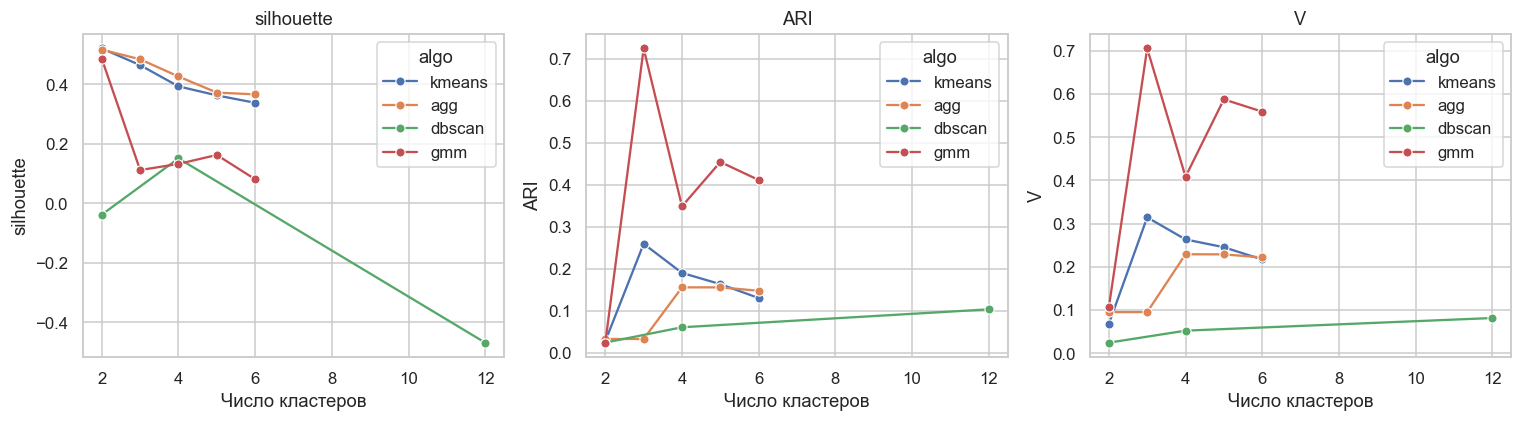

In [27]:

# Графики метрик
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, metric in zip(axes, ["silhouette", "ARI", "V"]):
    sns.lineplot(data=res_df.sort_values("clusters"), x="clusters", y=metric, hue="algo", marker="o", ax=ax)
    ax.set_xlabel("Число кластеров")
    ax.set_ylabel(metric)
    ax.set_title(metric)

plt.tight_layout()
plt.show()



## 10. Лучшая модель и визуализация кластеров

Из таблицы видно, что лучший результат даёт **GMM + PCA(3)** при k=3.
Ниже визуализация: форма точек соответствует истинному классу, цвет — найденному кластеру.


In [28]:

# Лучшая модель: GMM, k=3 на PCA(3)
gmm_best = GaussianMixture(n_components=3, random_state=42).fit(X_pca3)
labels_best_sample = gmm_best.predict(X_pca3_s)

print("ARI:", adjusted_rand_score(y_sample, labels_best_sample))
print("V-measure:", v_measure_score(y_sample, labels_best_sample))

print(pd.crosstab(pd.Series(labels_best_sample, name='cluster'), pd.Series(y_sample, name='class')))


ARI: 0.3605861801264914
V-measure: 0.40267358971492895
class    GALAXY   QSO  STAR
cluster                    
0          3454    32  3320
1           574  3387    34
2          8017   285   897


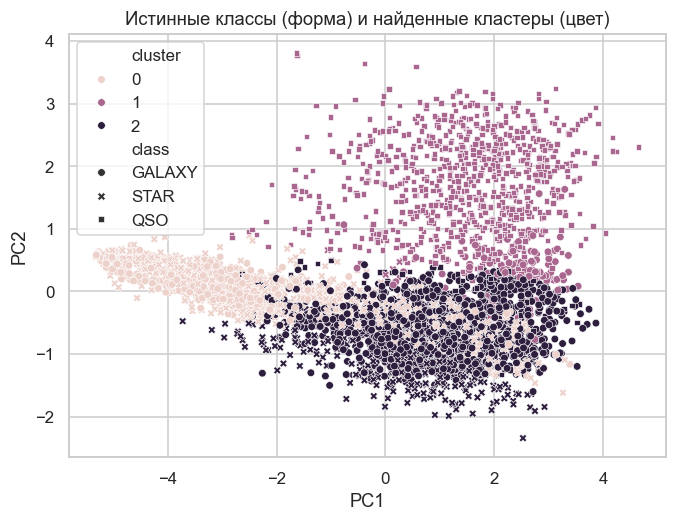

In [29]:

# Визуализация в 2D
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

plot_idx = rng.choice(len(X_pca2), size=5000, replace=False)
X_plot = X_pca2[plot_idx]

labels_full = gmm_best.predict(X_pca3)
labels_plot = labels_full[plot_idx]
true_plot = df_clean['class'].iloc[plot_idx].to_numpy()

plot_df = pd.DataFrame({
    "PC1": X_plot[:, 0],
    "PC2": X_plot[:, 1],
    "cluster": labels_plot,
    "class": true_plot,
})

plt.figure(figsize=(7, 5))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="cluster", style="class", s=25)
plt.title("Истинные классы (форма) и найденные кластеры (цвет)")
plt.show()



## 11. Подгруппа: яркие объекты (g < 19)

Проверим качество кластеризации на более ярких объектах.


In [30]:

# Подгруппа ярких объектов
mask_bright = df_clean['g'] < 19
X_bright = X_raw.loc[mask_bright]

# применяем тот же preprocessing
X_bright = X_bright.clip(lower, upper, axis=1)
X_bright_scaled = scaler.transform(X_bright)
X_bright_pca3 = pca3.transform(X_bright_scaled)

y_bright = df_clean.loc[mask_bright, 'class']

km_b = KMeans(n_clusters=3, n_init=10, random_state=42).fit(X_bright_pca3)
labels_b = km_b.labels_

print("Bright subset size:", len(X_bright_pca3))
print("ARI:", adjusted_rand_score(y_bright, labels_b))
print("V-measure:", v_measure_score(y_bright, labels_b))
print(pd.crosstab(pd.Series(labels_b, name='cluster'), pd.Series(y_bright, name='class')))


Bright subset size: 25324
ARI: 0.17758499787681956
V-measure: 0.14743306593373223
class    GALAXY  QSO  STAR
cluster                   
0          2210  164  1261
1          1023   92   619
2           582   44   340
